In [1]:
import numpy as np
np.random.seed(2023)
import random
random.seed(2023)
print('[INFO] Using numpy {0}'.format(np.__version__))

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras import initializers, regularizers, optimizers, losses
print('[INFO] Using keras {0}'.format(keras.__version__))

import sklearn
#from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
print('[INFO] Using sklearn {0}'.format(sklearn.__version__))

import pandas as pd
#import statsmodels

import sys
import time

import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline


# Globals
nlayers = 25  # 13 (CSC) + 9 (RPC) + 3 (GEM)

infile = '../test2/histos_tba.8.npz'

[INFO] Using numpy 1.12.1


Using Theano backend.


[INFO] Using keras 2.0.5
[INFO] Using sklearn 0.18.1


In [2]:
#### Load data ####

try:
    loaded = np.load(infile)
    the_parameters = loaded['parameters']
    the_variables = loaded['variables']
except:
    print('[ERROR] Failed to load data from file: {0}'.format(infile))

print('[INFO] Loaded the variables with shape {0}'.format(the_variables.shape))
print('[INFO] Loaded the parameters with shape {0}'.format(the_parameters.shape))

[INFO] Loaded the variables with shape (3953523, 103)
[INFO] Loaded the parameters with shape (3953523, 3)


In [3]:
class Encoder(object):

  def __init__(self, x, y):
    if x is not None and y is not None:
      assert(x.shape[1] == (nlayers * 4) + 3)
      assert(y.shape[1] == 3)
      assert(x.shape[0] == y.shape[0])

      self.nentries = x.shape[0]
      self.x_orig  = x
      self.y_orig  = y
      self.x_copy  = x.copy()
      self.y_copy  = y.copy()

      # Get views
      self.x_phi   = self.x_copy[:, nlayers*0:nlayers*1]
      self.x_theta = self.x_copy[:, nlayers*1:nlayers*2]
      self.x_bend  = self.x_copy[:, nlayers*2:nlayers*3]
      self.x_mask  = self.x_copy[:, nlayers*3:nlayers*4].astype(np.bool)  # this makes a copy
      self.x_road  = self.x_copy[:, nlayers*4:nlayers*5]  # ipt, ieta, iphi
      self.y_pt    = self.y_copy[:, 0]  # q/pT
      self.y_phi   = self.y_copy[:, 1]
      self.y_eta   = self.y_copy[:, 2]
      self.y_chi2  = None
      
      # Make event weight
      #self.w       = np.ones(self.y_pt.shape, dtype=np.float32)
      self.w       = np.abs(self.y_pt)/0.2 + 1.0
      
      # Subtract median phi from hit phis
      #self.x_phi_median    = self.x_road[:, 2] * 32 - 16  # multiply by 'quadstrip' unit (4 * 8)
      self.x_phi_median    = self.x_road[:, 2] * 16 - 8  # multiply by 'doublestrip' unit (2 * 8)
      self.x_phi_median    = self.x_phi_median[:, np.newaxis]
      self.x_phi          -= self.x_phi_median
      
      # Subtract median theta from hit thetas
      self.x_theta_median  = np.nanmedian(self.x_theta, axis=1)
      self.x_theta_median  = self.x_theta_median[:, np.newaxis]
      self.x_theta        -= self.x_theta_median
      
      # Zones
      self.x_ieta  = self.x_road[:, 1].astype(np.int32)
      
      # Standard scales
      self.x_mean  = np.nanmean(self.x_copy, axis=0)
      self.x_std   = np.nanstd(self.x_copy, axis=0)
      self.x_std   = self._handle_zero_in_scale(self.x_std)
      self.x_copy -= self.x_mean
      self.x_copy /= self.x_std
      
      ## Remove outlier hits by checking hit thetas
      #x_theta_tmp = np.abs(self.x_theta) > 4.0
      #self.x_phi  [x_theta_tmp] = np.nan
      #self.x_theta[x_theta_tmp] = np.nan
      #self.x_bend [x_theta_tmp] = np.nan
      #self.x_mask [x_theta_tmp] = 1.0
      
      ## Something wrong with GE2/1?
      #bad_ge21 = 23
      #self.x_phi  [:, bad_ge21] = np.nan
      #self.x_theta[:, bad_ge21] = np.nan
      #self.x_bend [:, bad_ge21] = np.nan
      #self.x_mask [:, bad_ge21] = 1.0
      
      # Add variables: theta_median and mode variables
      self.x_theta_median -= 3  # scaled to [0,1]
      self.x_theta_median /= 83
      hits_to_station = np.array((5,5,1,1,1,2,2,2,2,3,3,4,4,1,1,2,3,3,3,4,4,4,5,2,1), dtype=np.int32)  # '5' denotes ME1/1
      assert(len(hits_to_station) == nlayers)
      self.x_mode_vars = np.zeros((self.nentries, 5), dtype=np.float32)
      self.x_mode_vars[:,0] = np.any(self.x_mask[:,hits_to_station == 5] == 0, axis=1)
      self.x_mode_vars[:,1] = np.any(self.x_mask[:,hits_to_station == 1] == 0, axis=1)
      self.x_mode_vars[:,2] = np.any(self.x_mask[:,hits_to_station == 2] == 0, axis=1)
      self.x_mode_vars[:,3] = np.any(self.x_mask[:,hits_to_station == 3] == 0, axis=1)
      self.x_mode_vars[:,4] = np.any(self.x_mask[:,hits_to_station == 4] == 0, axis=1)
      
      # Remove NaN
      #np.nan_to_num(self.x_copy, copy=False)
      self.x_copy[np.isnan(self.x_copy)] = 0.0

  # Copied from scikit-learn
  def _handle_zero_in_scale(self, scale):
    scale[scale == 0.0] = 1.0
    return scale

  def get_x(self):
    #x_new = self.x_phi
    x_new = np.hstack((self.x_phi, self.x_theta, self.x_bend, self.x_theta_median, self.x_mode_vars))
    return x_new

  def get_x_mask(self):
    x_mask = self.x_mask.copy()
    return x_mask

  def get_y(self):
    y_new = self.y_pt.copy()
    return y_new

  def get_w(self):
    w_new = self.w.copy()
    return w_new
  
  def get_x_zone(self, zone):
    x_ieta_tmp = (self.x_ieta == zone)
    x_new = np.hstack((self.x_phi[x_ieta_tmp], self.x_theta[x_ieta_tmp], self.x_bend[x_ieta_tmp], self.x_theta_median[x_ieta_tmp], self.x_mode_vars[x_ieta_tmp]))
    return x_new
  
  def get_x_mask_zone(self, zone):
    x_ieta_tmp = (self.x_ieta == zone)
    x_mask = self.x_mask[x_ieta_tmp]
    return x_mask

  def save_encoder(self, filepath):
    np.savez_compressed(filepath, x_mean=self.x_mean, x_std=self.x_std)

  def load_endcoder(self, filepath):
    loaded = np.load(filepath)
    self.x_mean = loaded['x_mean']
    self.x_std = loaded['x_std']
    

In [4]:
#### Prepare data ####

# Preprocess data
encoder = Encoder(the_variables, the_parameters)
x, y, w, x_mask = encoder.get_x(), encoder.get_y(), encoder.get_w(), encoder.get_x_mask()
#encoder.save_encoder('encoder.npz')
#print('[INFO] Encoder is saved as encoder.npz')

# Split dataset in training and testing
x_train, x_test, y_train, y_test, w_train, w_test, x_mask_train, x_mask_test = train_test_split(x, y, w, x_mask, test_size=0.3)

nvariables = x_train.shape[1]
nparameters = 1
print('[INFO] Using {0} variables and {1} parameters'.format(nvariables, nparameters))

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/5.0-ghjeda6/lib/python2.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: Mean of empty slice
/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-numpy/1.12.1-mlhled2/lib/python2.7/site-packages/numpy-1.12.1-py2.7-linux-x86_64.egg/numpy/lib/nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


[INFO] Using 81 variables and 1 parameters


In [5]:
print x, y, w
print np.mean(x, axis=0)
print np.std(x, axis=0)
print np.isfinite(x).all()

[[-0.69595063  0.          0.         ...,  1.          1.          0.        ]
 [-0.33015883  0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.33125722 ...,  1.          1.          1.        ]
 ..., 
 [ 0.92240101  0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.2614204   0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.66696632 ...,  1.          1.          1.        ]] [-0.10976338 -0.03732378  0.04606546 ...,  0.1067722   0.11707978
  0.07033174] [ 1.54881692  1.18661892  1.23032737 ...,  1.53386092  1.58539891
  1.3516587 ]
[ -1.16163479e-08  -1.63351732e-08   6.16444273e-09  -8.79568596e-09
   0.00000000e+00  -8.18791008e-08   1.42959280e-07   1.23685329e-08
   1.67215717e-08   2.30435646e-07  -9.36387821e-08   6.49591385e-08
   2.16115367e-07   9.15457754e-09  -8.05541944e-08   9.15777250e-08
  -8.72471517e-08   1.18372220e-07  -1.65068244e-08  -4.74757522e-09
  -3.86

In [ ]:
from functools import partial

class Imputer(object):
  
  def __init__(self, x, x_mask):
    if x is not None:
      assert(x.shape[1] == (nlayers * 3) + 6)
      assert(x_mask.shape[1] == nlayers)

      self.nentries = x.shape[0]
      self.x_orig      = x
      self.x_mask_orig = x_mask
      self.x_copy      = x.copy()
      self.x_mask_copy = x_mask.copy()
    
      # Unpack variables
      self.x_phi          = self.x_copy[:, nlayers*0:nlayers*1]
      self.x_theta        = self.x_copy[:, nlayers*1:nlayers*2]
      self.x_bend         = self.x_copy[:, nlayers*2:nlayers*3]
      self.x_theta_median = self.x_copy[:, nlayers*3]
      self.x_mode_vars    = self.x_copy[:, nlayers*3+1:nlayers*3+6]
      
      # https://stackoverflow.com/a/35611142
      self.x_phi_hat = self._fill_missing_values(self.x_phi, self.x_mask_copy)
      self.x_theta_hat = self._fill_missing_values(self.x_theta, self.x_mask_copy)
      self.x_bend_hat = self._fill_missing_values(self.x_bend, self.x_mask_copy)
      
  def _fill_missing_values(self, x, x_mask):
    #
    svdmethod = partial(np.linalg.svd, full_matrices=False)
    tol = 1e-5
    maxiter = np.inf
    
    #
    x_hat = x.copy()
    valid = ~x_mask
    x_hat[~valid] = np.nan
    
    # initialize the missing values to their respective column means
    mu_hat = np.nanmean(x_hat, axis=0, keepdims=1)
    mu_hat[np.isnan(mu_hat)] = 0.0
    #sigma_hat = np.nanstd(x_hat, axis=0, keepdims=1)
    #sigma_hat[np.isnan(sigma_hat)] = 0.0
    #print mu_hat
    #print sigma_hat
    x_hat = np.where(valid, x_hat, mu_hat)
    
    halt = False
    ii = 0
    v_prev = 0

    while not halt:
      # SVD on filled-in data
      U, s, Vt = svdmethod(x_hat - mu_hat)
      S = np.diag(s)

      # impute missing values
      #x_hat[~valid] = (U.dot(np.diag(s)).dot(Vt) + mu_hat)[~valid]
      x_hat[~valid] = (np.dot(U, np.dot(S, Vt)) + mu_hat)[~valid]

      # update bias parameter
      mu_hat = np.mean(x_hat, axis=0, keepdims=1)

      # test convergence using relative change in trace norm
      v = s.sum()
      print('[INFO] ii={0} v={1} v_prev={2} s={3}'.format(ii, v, v_prev, s))
      
      if ii >= maxiter or ((v - v_prev) / v_prev) < tol:
          halt = True
      ii += 1
      v_prev = v
      
    return x_hat
  
  def get_x(self):
    x_new = np.hstack((self.x_phi_hat, self.x_theta_hat, self.x_bend_hat))
    return x_new
  
  def get_x_mask(self):
    x_mask_new = np.hstack((self.x_mask_copy, self.x_mask_copy, self.x_mask_copy))
    return x_mask_new


In [ ]:
imputer = Imputer(x[:100000], x_mask[:100000])

xx, xx_mask = imputer.get_x(), imputer.get_x_mask()

In [ ]:
print x[:100000].shape
print imputer.x_phi.shape
print imputer.x_phi
print imputer.x_phi_hat

In [ ]:
from functools import partial

class PCA(object):
  
  def __init__(self, x):
    
    U, s, Vt = self._fit(x)
    
    self.components_ = Vt
    n_samples = x.shape[0]
    self.explained_variance_ = (s ** 2) / (n_samples - 1)
    total_var = self.explained_variance_.sum()
    self.explained_variance_ratio_ = self.explained_variance_ / total_var
    self.singular_values_ = s.copy()
    
  def _fit(self, x):
    #
    svdmethod = partial(np.linalg.svd, full_matrices=False)
    x_hat = x.copy()
    mu_hat = np.mean(x_hat, axis=0, keepdims=1)
    
    #
    U, s, Vt = svdmethod(x_hat - mu_hat)
    S = np.diag(s)

    # flip eigenvectors' sign to enforce deterministic output
    U, Vt = self._svd_flip(U, Vt)
    return U, s, Vt    

  # Copied from scikit-learn
  def _svd_flip(self, u, v, u_based_decision=True):
    if u_based_decision:
        # columns of u, rows of v
        max_abs_cols = np.argmax(np.abs(u), axis=0)
        signs = np.sign(u[max_abs_cols, xrange(u.shape[1])])
        u *= signs
        v *= signs[:, np.newaxis]
    else:
        # rows of v, columns of u
        max_abs_rows = np.argmax(np.abs(v), axis=1)
        signs = np.sign(v[xrange(v.shape[0]), max_abs_rows])
        u *= signs
        v *= signs[:, np.newaxis]
    return u, v
    

In [ ]:
pca = PCA(xx)
print pca.explained_variance_.shape, pca.explained_variance_, pca.explained_variance_ratio_, pca.singular_values_

In [ ]:
for v in pca.explained_variance_ratio_:
  print v
print pca.explained_variance_ratio_.sum()

In [ ]:
xx_transformed = np.dot(pca.components_, xx.T).T
xx_transformed /= pca.singular_values_

print xx_transformed.shape, xx_transformed
print pca.singular_values_.shape, 1.0 / pca.singular_values_
print np.mean(xx_transformed, axis=1), np.std(xx_transformed, axis=1)

plt.hist(xx_transformed[:,0], bins=40)

#fig, axs = plt.subplots(76/4, 4, figsize=(4*4,4*76/4), tight_layout=True)
#for i in xrange(75):
#  hist = axs[(i/4, i%4)].hist(xx_transformed[:,i], bins=40)

In [ ]:
if False:
  from sklearn.decomposition import PCA as SL_PCA
  sl_pca = SL_PCA()
  sl_pca.fit(xx)

  print sl_pca.explained_variance_, sl_pca.explained_variance_ratio_

In [ ]:
if False:
  import scipy.linalg as LA
  xx_ = xx - xx.mean(0)
  e_values, e_vectors = LA.eigh(np.cov(xx_.T))
  print e_values, e_vectors

  idx = np.argsort(e_values)[::-1]
  e_vectors = e_vectors[:, idx]
  e_values = e_values[idx]

  n_samples = x.shape[0]
  explained_variance_ = e_values / (n_samples - 1)
  total_var = explained_variance_.sum()
  explained_variance_ratio_ = explained_variance_ / total_var
  print explained_variance_ratio_

In [ ]:
import pandas as pd

class APCA(object):
  
  def __init__(self, x, x_mask):
    
    #w, v = self._fit(x, x_mask)
    #s = np.sqrt(w)
    # Vt = v.T
    
    U, s, Vt = self._fit(x, x_mask)
    
    self.components_ = Vt
    n_samples = x.shape[0]
    self.explained_variance_ = (s ** 2) / (n_samples - 1)
    total_var = self.explained_variance_.sum()
    self.explained_variance_ratio_ = self.explained_variance_ / total_var
    self.singular_values_ = s.copy()
    
  def _fit(self, x, x_mask):
    x_copy = x.copy()
    x_mask_copy = x_mask.copy()
    
    x_copy[x_mask_copy] = np.nan
    x_copy[np.abs(x_copy) > 4.0] = np.nan
    x_copy[:, np.nanstd(x_copy, axis=0) == 0] = np.nan
    x_copy -= np.nanmean(x_copy, axis=0)
    
    df = pd.DataFrame(x_copy)
    df = df.dropna(axis=1, how='all')
    df_corr = df.corr()
    #df_cov = df.cov()
    #print df
    #print df_corr
    
    df_corr_v = df_corr.values
    df_corr_v[np.isnan(df_corr_v)] = 0.0
    
    #L = np.linalg.cholesky(df_corr_v)  # check if matrix is positive definite
    
    #q, r = np.linalg.qr(df_corr_v)
    
    #w, v = np.linalg.eig(df_corr_v)  # get eigenvalues and eigenvectors
    #ind = np.argsort(w)[::-1]  # sort by largest eigenvalues
    #v = v[:, ind]
    #w = w[ind]
    
    U, s, Vt = np.linalg.svd(df_corr_v)
    return U, s, Vt
  
  def transform(self, x, x_mask):
    x_copy = x.copy()
    x_mask_copy = x_mask.copy()
    
    x_copy[x_mask_copy] = np.nan
    x_copy[np.abs(x_copy) > 4.0] = np.nan
    x_mask_copy[:, np.nanstd(x_copy, axis=0) == 0] = np.nan
    x_copy[:, np.nanstd(x_copy, axis=0) == 0] = np.nan
    x_copy -= np.nanmean(x_copy, axis=0)
    
    df = pd.DataFrame(x_copy)
    df = df.dropna(axis=1, how='all')
    #print df
    
    df_v = df.values
    df_v[np.isnan(df_v)] = 0.0
    
    df_mask = pd.DataFrame(x_mask_copy)
    df_mask = df_mask.dropna(axis=1, how='all')
    df_mask_v = df_mask.values
    
    #df_transformed = np.dot(self.components_, df_v.T).T
    df_transformed = np.dot(df_v, self.components_)
    return df_transformed, df_mask_v

  

In [ ]:
apca = APCA(xx, xx_mask)
print apca.explained_variance_.shape, apca.explained_variance_, apca.explained_variance_ratio_, apca.singular_values_

In [ ]:
xx_transformed, xx_transformed_mask = apca.transform(xx, xx_mask)
#xx_transformed /= apca.singular_values_

print xx_transformed.shape, xx_transformed
print apca.singular_values_.shape, 1.0 / apca.singular_values_
print np.mean(xx_transformed, axis=1), np.std(xx_transformed, axis=1)

#plt.hist(xx_transformed[:,1][~xx_mask[:,1]], bins=40)
#print np.mean(xx_transformed[:,1][~xx_mask[:,1]]), np.std(xx_transformed[:,1][~xx_mask[:,1]])


fig, axs = plt.subplots(76/4, 4, figsize=(4*4,4*76/4), tight_layout=True)
for i in xrange(58):
  hist = axs[(i/4, i%4)].hist(xx_transformed[:,i][xx_transformed_mask[:,i]], bins=40)
  print np.mean(xx_transformed[:,i][xx_transformed_mask[:,i]]), np.std(xx_transformed[:,i][xx_transformed_mask[:,i]])

In [ ]:
x_copy = xx.copy()

x_copy[np.abs(x_copy) > 4.0] = np.nan

x_copy[:, np.sum(x_copy, axis=0) == 0] = np.nan
    
x_copy -= np.nanmean(x_copy, axis=0)
    
df = pd.DataFrame(x_copy)


print x_copy
print df

df = df.dropna(axis=1, how='all')

print df

In [ ]:
xx_transformed = np.dot(pca.components_, xx.T).T
xx_transformed /= pca.singular_values_

print xx_transformed.shape, xx_transformed
print pca.singular_values_.shape, 1.0 / pca.singular_values_
print np.mean(xx_transformed, axis=1), np.std(xx_transformed, axis=1)

plt.hist(xx_transformed[:,0], bins=40)

In [ ]:
###### RETRY

In [ ]:
zone = 5
x, x_mask = encoder.get_x_zone(zone), encoder.get_x_mask_zone(zone)
print x.shape, x_mask.shape
print (encoder.x_orig[:, 101]==5).sum()

x, x_mask = x[:100000,:75], x_mask[:100000]

#print encoder.x_orig[:, 0:2], encoder.x_orig[:, 101]
print encoder.x_orig[encoder.x_orig[:, 101]==5][:, 0:2][:10]
print encoder.x_orig[encoder.x_orig[:, 101]==5][:, 75+0:75+2][:10]


In [ ]:
x_copy = x.copy()
x_mask_copy = x_mask.copy()
    
x_copy[np.hstack((x_mask_copy, x_mask_copy, x_mask_copy))] = np.nan
x_copy[np.abs(x_copy) > 4.0] = np.nan
x_copy[:, np.nanstd(x_copy, axis=0) == 0] = np.nan
x_copy -= np.nanmean(x_copy, axis=0)
    
df = pd.DataFrame(x_copy)
#df = df.dropna(axis=1, how='all')

df_corr = df.corr()
#df_corr = df.cov()
print df
print df_corr
    
df_v = df.values
df_v[np.isnan(df_v)] = 0.0
df_corr_v = df_corr.values
df_corr_v[np.isnan(df_corr_v)] = 0.0
    
#L = np.linalg.cholesky(df_corr_v)  # check if matrix is positive definite

#q, r = np.linalg.qr(df_corr_v)  # QR eigendecomposition

#w, v = np.linalg.eig(df_corr_v)  # get eigenvalues and eigenvectors
#ind = np.argsort(w)[::-1]  # sort by largest eigenvalues
#v = v[:, ind]
#w = w[ind]

U, s, Vt = np.linalg.svd(df_corr_v)
print U.shape, s.shape, Vt.shape, np.isfinite(Vt).all()
print s
print Vt


In [ ]:
x_transformed = np.dot(Vt, df_v.T).T
print x_transformed

In [ ]:
#print xx_transformed.shape, xx_transformed
#print apca.singular_values_.shape, 1.0 / apca.singular_values_
#print np.mean(xx_transformed, axis=1), np.std(xx_transformed, axis=1)

print x_transformed.shape, x_mask.shape, s.shape, np.isfinite(x_transformed).all()
#print np.mean(x_transformed[:,1][~x_mask[:,1]]), np.std(x_transformed[:,1][~x_mask[:,1]]), s
print np.mean(x_transformed[:,1]), np.std(x_transformed[:,1]), s
plt.hist(x_transformed[:,1], bins=40)

fig, axs = plt.subplots(76/4, 4, figsize=(4*4,4*76/4), tight_layout=True)
for i in xrange(75):
  hist = axs[(i/4, i%4)].hist(x_transformed[:,i], bins=40)
  print np.mean(x_transformed[:,i]), np.std(x_transformed[:,i])

In [126]:
class BPCA(object):
  
  def __init__(self, encoder):
    
    nentries = 100000
    nvariables = 75
    
    self.Vt_all = []
    self.v_n_all = []
    self.v_mean_all = []
    self.v_std_all = []
    
    for zone in xrange(6):
      x, x_mask = encoder.get_x_zone(zone), encoder.get_x_mask_zone(zone)
      #print x.shape, x_mask.shape
      #print (encoder.x_orig[:, 101]==zone).sum()
      
      x, x_mask = x[:nentries,:nvariables], x_mask[:nentries]
      
      U, s, Vt, v_n, v_mean, v_std = self._fit(x, x_mask)
      self.Vt_all.append(Vt)
      self.v_n_all.append(v_n)
      self.v_mean_all.append(v_mean)
      self.v_std_all.append(v_std)
    
    self.chi2_all = []
    self.ndof_all = []
    
    for iz, zone in enumerate(xrange(6)):
      x, x_mask = encoder.get_x_zone(zone), encoder.get_x_mask_zone(zone)
      x = x[:,:nvariables]
      
      Vt = self.Vt_all[iz]
      v_n = self.v_n_all[iz]
      v_mean = self.v_mean_all[iz]
      v_std = self.v_std_all[iz]
      
      chi2, ndof = self._transform(x, x_mask, Vt, v_n, v_mean, v_std)
      self.chi2_all.append(chi2)
      self.ndof_all.append(ndof)
  
  def _fit(self, x, x_mask):
    x_copy = x.copy()
    x_mask_copy = x_mask.copy()
    
    x_copy[np.hstack((x_mask_copy, x_mask_copy, x_mask_copy))] = np.nan
    x_copy[np.abs(x_copy) > 4.0] = np.nan
    x_copy[:, np.nanstd(x_copy, axis=0) == 0] = np.nan
    x_mean = np.nanmean(x_copy, axis=0)
    
    df = pd.DataFrame(x_copy - x_mean)
    #df = df.dropna(axis=1, how='all')

    df_corr = df.corr()
    #df_corr = df.cov()
    #print df
    #print df_corr
    
    df_v = df.values
    df_v[np.isnan(df_v)] = 0.0
    df_corr_v = df_corr.values
    df_corr_v[np.isnan(df_corr_v)] = 0.0
    
    #L = np.linalg.cholesky(df_corr_v)  # check if matrix is positive definite

    #q, r = np.linalg.qr(df_corr_v)  # QR eigendecomposition

    #w, v = np.linalg.eig(df_corr_v)  # get eigenvalues and eigenvectors
    #ind = np.argsort(w)[::-1]  # sort by largest eigenvalues
    #v = v[:, ind]
    #w = w[ind]

    U, s, Vt = np.linalg.svd(df_corr_v)
    assert all(s[i] >= s[i+1] for i in xrange(len(s)-1))  # check is sorted
    assert all(s[i] > 0 for i in xrange(len(s)))  # check non-negative s
    #print U.shape, s.shape, Vt.shape, np.isfinite(Vt).all()
    #print Vt
    
    x_copy[np.isnan(x_copy)] = 0.0
    #x_transformed = np.dot(Vt, x_copy.T).T
    x_transformed = np.dot(x_copy, Vt.T)
    
    v_n = s.size - np.searchsorted(s[::-1], 1e-03, side='right')
    v_mean = np.mean(x_transformed, axis=0)
    v_std = np.std(x_transformed, axis=0)
    v_std[v_std == 0.0] = 1.0
    #print s, v_n, v_mean, v_std
    #print np.sqrt(s), np.sqrt(s)/v_std
    return U, s, Vt, v_n, v_mean, v_std
  
  def _transform(self, x, x_mask, Vt, v_n, v_mean, v_std):
    x_copy = x.copy()
    x_mask_copy = x_mask.copy()
    
    x_transformed = np.dot(x_copy, Vt.T)
    #print x_transformed
    
    x_transformed -= v_mean
    x_transformed /= v_std
    x_transformed **= 2
    x_transformed = x_transformed[:,2:v_n]
    #print x_transformed
    
    chi2 = np.sum(x_transformed, axis=1)
    ndof = np.sum(~x_mask_copy, axis=1) - 2  # pt, phi
    return chi2, ndof
    

In [127]:
bpca = BPCA(encoder)


/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/5.0-ghjeda6/lib/python2.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice


(642887,) True
(642887,) True
[ 14.49135312  13.8577157   14.22653427 ...,  66.90949651  29.36153502
  15.07525094] [5 6 5 ..., 4 5 5]


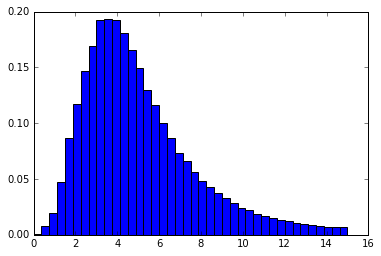

In [128]:
print bpca.chi2_all[0].shape, np.isfinite(bpca.chi2_all[0]).all()
print bpca.ndof_all[0].shape, np.isfinite(bpca.ndof_all[0]).all()

print bpca.chi2_all[0], bpca.ndof_all[0]
y = bpca.chi2_all[0]/bpca.ndof_all[0]
y = y[bpca.ndof_all[0] == 5]

fig, ax = plt.subplots()
_ = ax.hist(y, bins=40, range=(0,15), normed=True)

print bpca.v_n_all

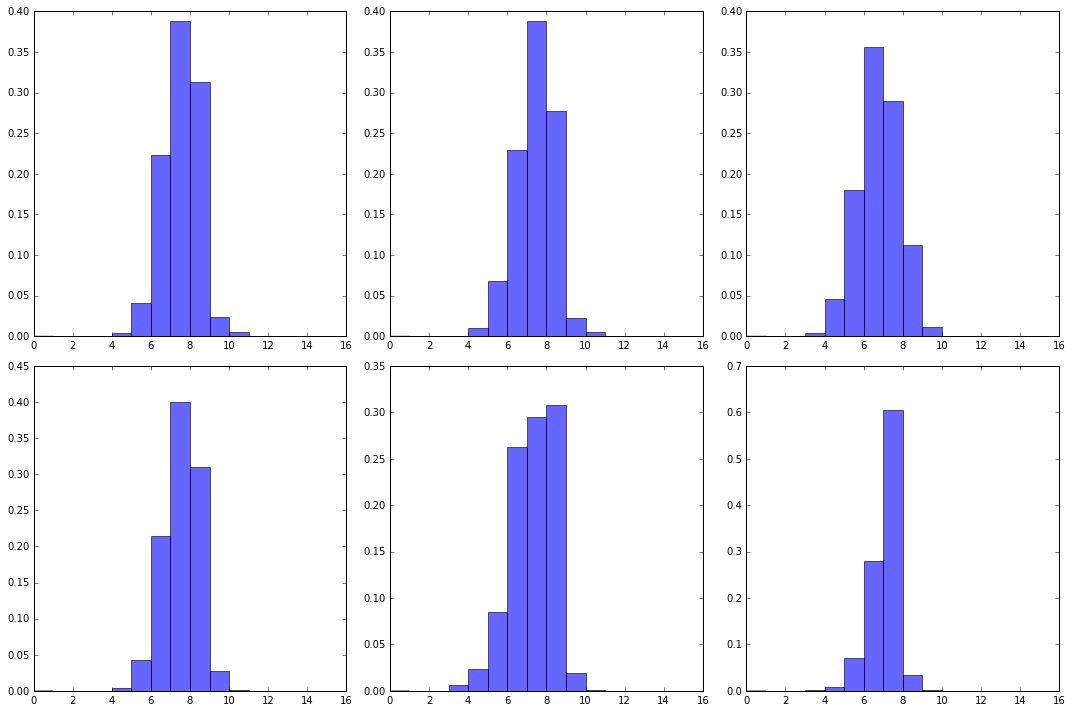

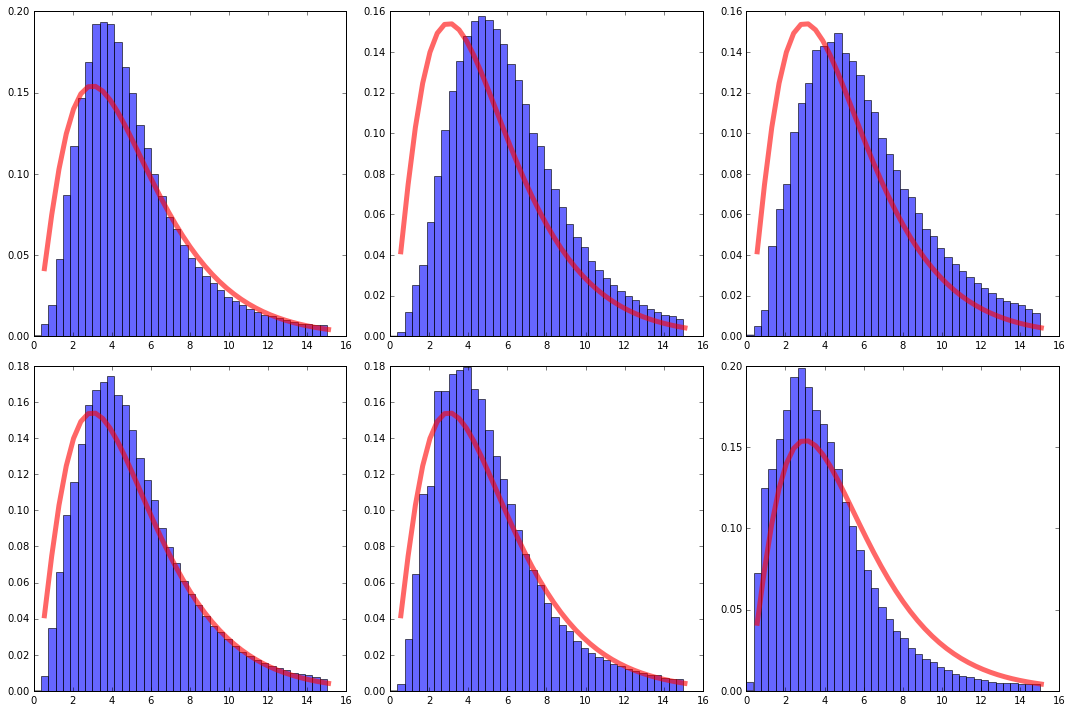

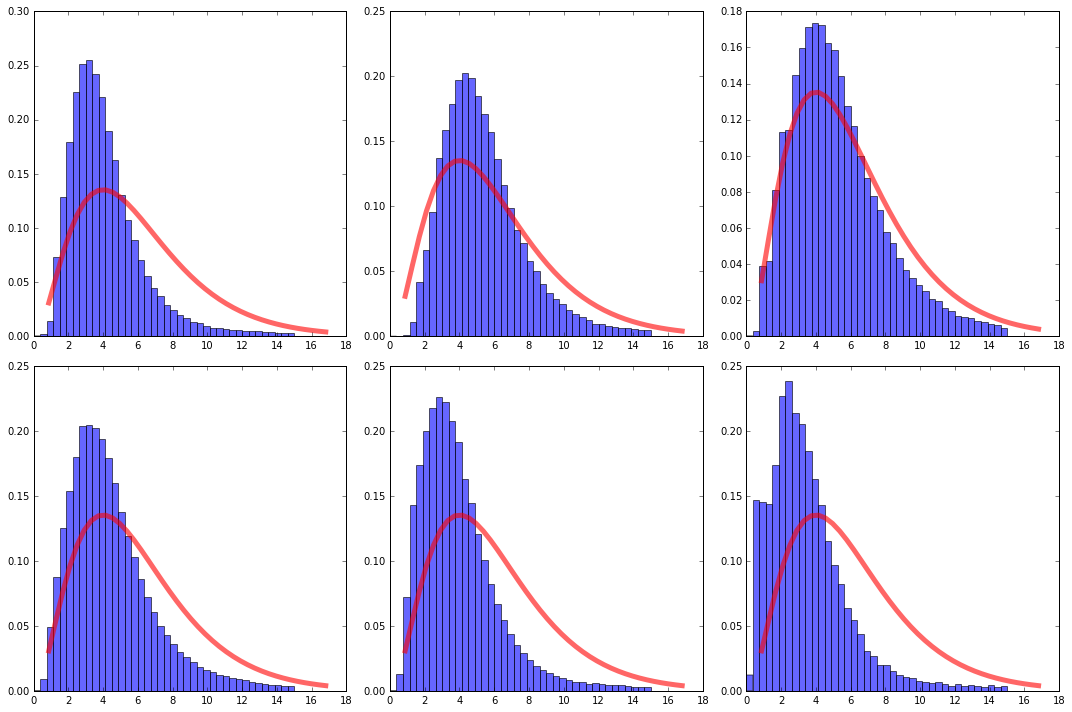

In [145]:
from scipy.stats import chi2

fig, ax = plt.subplots(6/3,3, figsize=(5*3,5*6/3), tight_layout=True)
for i in xrange(6):
  _ = ax[i/3,i%3].hist(bpca.ndof_all[i] + 2, bins=15, range=(0,15), normed=True, alpha=0.6)

df = 5
x = np.linspace(chi2.ppf(0.01, df), chi2.ppf(0.99, df), 40)

fig, ax = plt.subplots(6/3,3, figsize=(5*3,5*6/3), tight_layout=True)
for i in xrange(6):
  y = bpca.chi2_all[i]/bpca.ndof_all[i]
  y = y[bpca.ndof_all[i] == df]
  _ = ax[i/3,i%3].hist(y, bins=40, range=(0,15), normed=True, alpha=0.6)
  ax[i/3,i%3].plot(x, chi2.pdf(x, df), 'r-', lw=5, alpha=0.6, label='chi2 pdf')


df = 6
x = np.linspace(chi2.ppf(0.01, df), chi2.ppf(0.99, df), 40)

fig, ax = plt.subplots(6/3,3, figsize=(5*3,5*6/3), tight_layout=True)
for i in xrange(6):
  y = bpca.chi2_all[i]/bpca.ndof_all[i]
  y = y[bpca.ndof_all[i] == df]
  _ = ax[i/3,i%3].hist(y, bins=40, range=(0,15), normed=True, alpha=0.6)
  ax[i/3,i%3].plot(x, chi2.pdf(x, df), 'r-', lw=5, alpha=0.6, label='chi2 pdf')